In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, date

## Group Assignment
### Team Number: 11
### Team Member Names: Jeffrey, Ray, Baldeep
### Team Strategy Chosen: RISKY (RISKY OR SAFE)

# Initialization of Variables

In [2]:
# List of Tickers to Choose From
ticker_list = pd.read_csv("Tickers.csv")

# Initial Capital (CAD)
capital = 750000

# Trading Fee
trading_fee = 4.95

# Restrictions
avg_month_vol = 150000
min_month_days = 18
currency = ['USD', 'CAD']

# Number of stocks in our Portfolio
num_stocks = 10

# Minimum weight for each stock in the portfolio (in decimals)
min_weight = 1 / (2 * num_stocks)

# Maximum weight for each stock in the portfolio (in decimals)
max_weight = 0.2

# Day that we will purchase stocks for our portfolio
purchase_date = '2023-11-25'

In [3]:
# Portfolios
Portfolio_Final = pd.DataFrame()
Stocks_Final = pd.DataFrame()

# Filtering the tickers

## Before creating our portfolio of stocks, we must first create a filter function to filter out unwanted tickers for this assignment. 

We have to consider:
1) Are the stocks delisted?
2) Are the stocks denominated in USD or CAD?
3) Do the months have at least 18 trading days?
4) Do the stocks have an average monthly volume of at least 150 000 shares? 


1) To do this, we loop through every ticker in the ticker_lst and check if calling fast_info produces an error. If it produces an error, we know the stock is delisted, so we don't add that ticker to the new ticker list. 

2) We get the fast_info of the stock and check if the currency is either USD or CAD. If it is, we add it to the new ticker list. 

3) We use a stock index from the TSX and another from the NYSE and concat the historical data together such that only the days that appear in both are kept. Then, we loop through every month and count the total number of days. If the number of days is less than 18, then we add it to a list and remove the month from the dataframes later. 

4) Using the historical data, we calculate the average monthly volume for each stock by looping through all the valid stocks and then using the mean function. If the average monthly volume is less than 150 000, then we remove the stock from the stock list. 

In [4]:
#define start date and end date variables
start_date = '2023-01-01'
end_date = '2023-10-31'

#define holder variables
stock_hist_data = []
invalid_months = []

#produce a list of all the tickers
ticker_lst = ticker_list[ticker_list.columns[0]]

#filter stocks variable 
def filter_stocks(ticker_lst):
    new_ticker_lst=[]
    
    #loop through every ticker in the ticker_lst and check if it is listed and has a currency of USD or CAD
    for cur_ticker in ticker_lst:
        info = yf.Ticker(cur_ticker).fast_info
        try:
            #check if the currency is USD or CAD
            if(info.currency == 'USD' or info.currency == 'CAD'):
                new_ticker_lst.append(cur_ticker)
        except:
            #output a statement if the stock is delisted
            print(f"{cur_ticker} is not a valid ticker")
    
    #get the historical data of each ticker and add it to a list
    for cur_ticker in new_ticker_lst:
        temp_ticker = yf.Ticker(cur_ticker)
        hist = temp_ticker.history(start=start_date, end=end_date, interval = '1mo')
        stock_hist_data.append(hist)
    
    cad_index = '^GSPTSE' #S&P/TSX Composite Index (CAD)
    usa_index = '^GSPC' #S&P500 Composite Index (USD)
    
    #loop through every month and check if the month has less than 18 trading days
    for cur_month in range(1, 11):
        #get the historical dataframes of the two indexes
        cad_days = yf.Ticker(cad_index).history(start = str(date(2023, cur_month, 1)), end = str(date(2023, cur_month+1, 1)))
        usd_days = yf.Ticker(usa_index).history(start = str(date(2023, cur_month, 1)), end = str(date(2023, cur_month+1, 1)))
        #merge the two dataframes and only keep the duplicates
        total_days = cad_days.reindex(usd_days.index)
        num_days = len(total_days)
        if num_days < min_month_days:
            invalid_months.append(cur_month)
            
    #remove the months that have less than 18 trading days
    for i in range(len(stock_hist_data)):
        cur_hist = stock_hist_data[i]
        for month in invalid_months:
            if month < 10:
                cur_hist.filter(like!=f'2023-0{month}', axis=0)
            else:
                cur_hist.filter(like != f'2023-{month}', axis=0)
    #Calculate the average monthly volume for each stock and remove the stock if it is less than 150 000
    for i in range(len(new_ticker_lst)): 
        cur_ticker = new_ticker_lst[i]
        cur_hist = stock_hist_data[i]
        avgMonthlyVolume = cur_hist['Volume'].mean()
        #check if the average monthly volume is less than 150 000 and remove the stock if it is
        if avgMonthlyVolume < avg_month_vol:
            new_ticker_lst.remove(cur_ticker)
            stock_hist_data.remove(cur_hist)
    return new_ticker_lst

#call the function
filtered_ticker_lst = filter_stocks(ticker_lst)
filtered_ticker_lst

AGN is not a valid ticker
CELG is not a valid ticker
MON is not a valid ticker
RTN is not a valid ticker


['ABBV',
 'ABT',
 'ACN',
 'AIG',
 'AMZN',
 'AXP',
 'BA',
 'BAC',
 'BIIB',
 'BK',
 'BLK',
 'BMY',
 'C',
 'CAT',
 'CL',
 'KO',
 'LLY',
 'LMT',
 'MO',
 'MRK',
 'PEP',
 'PFE',
 'PG',
 'PM',
 'PYPL',
 'QCOM',
 'RY.TO',
 'SHOP.TO',
 'T.TO',
 'TD.TO',
 'TXN',
 'UNH',
 'UNP',
 'UPS',
 'USB']

# Computing Historical Data

In [5]:
#define start date and end date
compute_start_date = '2022-01-01'
compute_end_date = '2023-11-21'

#get the exchange rate for the compute start date
cad_usd = yf.Ticker('CADUSD=X')
cad_usd_close = cad_usd.history(start=compute_start_date, end=compute_end_date).Close
exchange_rate = cad_usd_close.iloc[0]

weekly_pct_change = pd.DataFrame()

#loop through each ticker and add the percent change of the weekly closing price to the dataframe
for ticker in filtered_ticker_lst:
    hist = yf.Ticker(ticker).history(start=compute_start_date, end=compute_end_date, interval = '1wk')
    temp_currency = yf.Ticker(ticker).fast_info['currency']
    #convert the USD close prices to CAD
    if temp_currency == 'USD':
        hist['Close'] = hist['Close']/exchange_rate
    weekly_pct_change[ticker] = hist.Close.pct_change()

#drop the NaN values
weekly_pct_change = weekly_pct_change.dropna()

#output the weekly percent changes of each stock
weekly_pct_change

    


,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,BK,...,QCOM,RY.TO,SHOP.TO,T.TO,TD.TO,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-08 00:00:00-05:00,0.007340,-0.054588,-0.046905,0.019262,-0.002559,-0.031869,0.048538,-0.025823,0.028805,0.020375,...,0.045895,0.039083,-0.044331,0.005395,0.032304,0.042187,0.022002,-0.033401,-0.053264,0.036885
2022-01-15 00:00:00-05:00,-0.018550,-0.014717,-0.047713,-0.074140,-0.120237,-0.057363,-0.090813,-0.062409,-0.078479,-0.100943,...,-0.125921,-0.017924,-0.196567,-0.014085,-0.021081,-0.060799,-0.016045,0.000244,-0.022224,-0.128854
2022-01-22 00:00:00-05:00,0.045007,-0.003815,0.021512,-0.006281,0.009359,0.115409,-0.072381,0.021149,0.021268,0.022735,...,0.011399,-0.010162,0.003224,0.016667,-0.000897,0.009394,0.010603,-0.001624,-0.018321,0.054084
2022-01-29 00:00:00-05:00,0.019794,0.034783,0.013563,0.070752,0.094886,0.049644,0.083329,0.052540,-0.016340,0.063135,...,0.075895,0.034432,0.003824,0.031114,0.053987,-0.026707,0.036712,-0.014394,0.133871,0.027893
2022-02-05 00:00:00-05:00,0.009669,-0.032534,-0.052719,-0.004099,-0.027569,0.032069,0.028336,-0.007457,-0.031328,0.008413,...,-0.082632,-0.004222,-0.025656,0.024335,0.020735,-0.040952,-0.010431,-0.014770,-0.050269,-0.019263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-21 00:00:00-04:00,-0.049921,-0.040608,-0.023434,0.000168,0.020532,-0.001837,-0.001944,-0.043330,-0.089066,-0.000720,...,-0.019976,-0.022881,-0.082026,-0.004973,-0.032397,-0.031730,-0.004497,-0.045519,-0.112727,-0.009376
2023-10-28 00:00:00-04:00,0.017923,0.032202,0.080851,0.070721,0.085017,0.081028,0.085481,0.129122,0.063875,0.097976,...,0.122675,0.083128,0.306294,0.101772,0.063288,0.049679,0.011894,0.051606,0.059556,0.158290
2023-11-04 00:00:00-04:00,-0.020011,-0.019512,0.019777,0.001255,0.035786,0.010605,0.008203,-0.026038,-0.099038,0.009061,...,0.039240,0.006290,0.007257,-0.018969,0.012102,-0.011255,0.019420,-0.003017,-0.033249,-0.036348


## Standard Deviation


In creating a risky portfolio, we require a group of stock tickers that are unpredictable and have a high varience when compared to their mean values. These tickers would have large periods of unprecedented growhth and loss, and would be an investors greatest dream come true, or worst nightmare, depending on the performance ot the stock. For the purposes of our portfolio, we are calculating the standard deviation of all of the filtered tickers, and moving forward with the 10 tickers with the highest standard deviations, as this will make up our portfolio of risky, volatile stocks. 

\begin{align*}
\sigma_X=\sqrt{\frac{\sum(x_i-\overline{X})^2}{N}}
\end{align*}

In [32]:
# Function to return the tickers of the firms with the ten highest standard deviations in the original ticker list
def highest_std(dataframe):
    
    # Setting variables
    temp_std = 0 
    list_of_stds = []
    list_of_tickers = []
    
    # Looping through every column in the datafarme
    for x in dataframe.columns:
        temp_std = abs(dataframe[x].std())
        list_of_stds.append(temp_std)
    
    # Return a dataframe with the list of standard deviations
    global stds_dataframe
    stds_dataframe = pd.DataFrame(list_of_stds, index=dataframe.columns, columns=['std'])
    stds_dataframe.sort_values("std", inplace=True, ascending=False)
    
    for x in range (len(stds_dataframe.index)):
        temp_ticker = (stds_dataframe.index[x])
        list_of_tickers.append(temp_ticker)
        
    
    return list_of_tickers

print(highest_std(weekly_pct_change))

['SHOP.TO', 'PYPL', 'BA', 'AMZN', 'QCOM', 'USB', 'BIIB', 'CAT', 'BLK', 'AXP', 'BAC', 'C', 'ACN', 'LLY', 'UPS', 'BK', 'AIG', 'TXN', 'LMT', 'ABT', 'UNP', 'PFE', 'PM', 'ABBV', 'UNH', 'MO', 'BMY', 'PG', 'MRK', 'TD.TO', 'CL', 'T.TO', 'KO', 'PEP', 'RY.TO']


## Correlation and Covarience

Since we have 10 tickers, then the minimum weight for each is 5% and the max is 20%. We want highest variance and
volatility of the stocks (risky strategy). So, loop through the 10 tickers found above with the highest standard
deviation, and for each (call this stock the base stock), find the 9 stocks that have the highest correlation to to
the base stock in decreasing order. (meaning that the first stock will have the highest correlation
to the base stock, the second stock will have the second highest correlation to the base stock, and so on.) Then,
put 20% in the base stock, the first stock, the second stock, 10% in the third stock, and 5% in the rest in order
to maximize the expected combined correlation (weight * correlation). To calculate correlation of two securities, first we need to know how to calculate the covarience of the two securities, which can be found using the following formula, where 
$x_i, y_i$ represents the individual returns of a securities X and Y, $\overline{X}, \overline{Y}$ represent the mean returns of securities X and Y, and $N$ is the total number of observations/time periods.

\begin{align*}
COV(X,Y)=\frac{\sum(x_i-\overline{X})\times(y_i-\overline{Y})}{N}
\end{align*}

Covarience provides us an understanding on how two variables change in relation to each other statistically. Correlation is essentially the same as covarience, but is more standardized by dividing the covarience by the standard deviation of the datasets. Correlation ranges from -1 to 1, with a value of 1 suggesting that both variables are moving in tandem, and a value of -1 suggesting that the variables move directly opposite of each other. To calculate correlation, take the covarience calculated above and divide by the product of the standard deviation of security X and security Y

\begin{align*}
COR(X,Y)=\frac{COV(X,Y)}{\sigma_X \times \sigma_Y}
\end{align*}


---------------------------------------------------------------------------
The portfolio with the highest average percent returns is portfolio 25
---------------------------------------------------------------------------


,UNH,MRK,LLY,PEP,LMT,PFE,ABBV,KO,PG,BMY
Date,,,,,,,,,,
2022-01-08 00:00:00-05:00,0.022002,0.013449,-0.059268,0.008961,0.034653,-0.013819,0.007340,0.017570,-0.018004,0.042480
2022-01-15 00:00:00-05:00,-0.016045,-0.017203,-0.004342,-0.008085,-0.003811,-0.039309,-0.018550,-0.015312,0.017583,-0.021408
2022-01-22 00:00:00-05:00,0.010603,0.011503,0.008393,-0.008897,0.059133,0.029172,0.045007,0.006452,-0.007707,0.021561
2022-01-29 00:00:00-05:00,0.036712,-0.028925,-0.011546,-0.001042,-0.009716,-0.017063,0.019794,0.001972,0.006418,0.001232
2022-02-05 00:00:00-05:00,-0.010431,-0.024440,-0.026953,-0.022668,0.017620,-0.041887,0.009669,-0.010991,-0.032440,0.029081


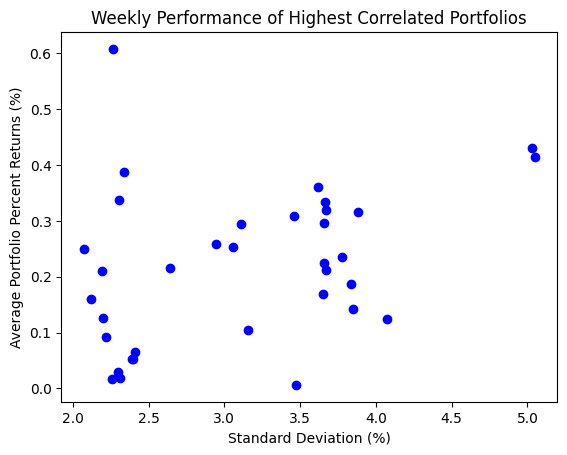

In [34]:
# To find which portfolio gives the best percent returns
pfl_pct_returns = []

# Made into a function for future use
def correlation_pfl(tkr_lst, return_lst):
    
    '''
    From all the tickers in tkr_lst, finds the next 9 highest correlated stocks and creates a weighted portfolio. Then 
    using historical data from Jan 1, 2022 to Nov 21, 2023, find the portfolio average percent returns and appends the 
    value to the return_lst
    ''' 
    for i in tkr_lst:
        temp_df = pd.DataFrame()
        correlation = weekly_pct_change.corr()[i]
        correlation = correlation.sort_values(ascending=False)
        
        # List of largest correlation values to the base stock
        stock_lst = [k for k in (correlation.index[:10])]
        
        # To get the portfolio of each and calculate average percent returns
        for x in stock_lst:
            temp_df[x] = weekly_pct_change[x]
        
        # Finding the weighted returns of each stock in the portfolio
        count = 0
        for x in temp_df.columns:
            if count <= 2:
                temp_df[x] = temp_df[x] * 0.2
                count += 1
            elif count == 3:
                temp_df[x] = temp_df[x] * 0.1
                count += 1
            else:
                temp_df[x] = temp_df[x] * 0.05
                count += 1
        
        # To get the average portfolio percent returns in order to calculate standard eviation for graphing purposes
        temp_df["Portfolio Average Returns"] = temp_df.sum(1)
        
        # Finding the weighted average portfolio percent returns. Take absolute value of the average portfolio percent
        # returns since all we care about is maximum volatility and risk
        # (Increase or Decrease in Portfolio value does not matter)
        avg_std = temp_df["Portfolio Average Returns"].std()
        avg_pct_returns = temp_df.values.sum() / len(temp_df.index)
        return_lst.append(abs(avg_pct_returns))
        plt.scatter(avg_std * 100, abs(avg_pct_returns) * 100, color='b')
        plt.title("Weekly Performance of Highest Correlated Portfolios")
        plt.xlabel("Standard Deviation (%)")
        plt.ylabel("Average Portfolio Percent Returns (%)")

# Running the Function
correlation_pfl(highest_std(weekly_pct_change), pfl_pct_returns)
    
# Now find the index of the highest average percent returns and make a portfolio
max_index = pfl_pct_returns.index(max(pfl_pct_returns))
print("-"*75)
print(f"The portfolio with the highest average percent returns is portfolio {max_index+1}")
print("-"*75)

# Make the portfolio with the corresponding base stock
pfl = pd.DataFrame()
base_stock = highest_std(weekly_pct_change)[max_index]
correlation = weekly_pct_change.corr()[base_stock]
correlation = correlation.sort_values(ascending=False)
stock_lst = [k for k in (correlation.index[:10])]

for y in stock_lst:
    pfl[y] = weekly_pct_change[y]
    
display(pfl.head())

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here.